<a href="https://colab.research.google.com/github/AN461/Machine_Learning---Early-Warning-Prediction-of-Environmental-Parameters/blob/main/XG_BOOST_FOR_TEMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from scipy.fft import fft

In [ ]:
df1=pd.read_csv('/content/sample_data/Hutti_LoRawan_v3_merged (1).csv')
df_CO2=pd.read_csv('/content/sample_data/january_2024_co2_data (2).csv')
df_CO = pd.read_csv("/content/sample_data/january_2024_co_data.csv")
df_NO = pd.read_csv("/content/sample_data/january_2024_no_data.csv")
df_temp = pd.read_csv("/content/sample_data/january_2024_Temp.csv")
df_humidity = pd.read_csv("/content/sample_data/january_2024_Humi.csv")

In [ ]:
df2 = df_CO2

In [ ]:
df2['CO'] = df_CO['CO']
df2['NO'] = df_NO['NO']
df2['Temp'] = df_temp['Temp']
df2['Humi'] = df_humidity['Humi']

In [ ]:
df2

,DateTime,CO2,CO,NO,Temp,Humi
0,12/31/2023 0:00,544,0,0,29.8,61.4
1,12/31/2023 0:05,546,0,0,29.8,61.4
2,12/31/2023 0:10,549,0,0,29.8,61.4
3,12/31/2023 0:15,546,0,0,29.6,61.4
4,12/31/2023 0:20,548,0,0,29.6,61.4
...,...,...,...,...,...,...
9211,1/31/2024 23:35,550,0,0,29.2,59.9
9212,1/31/2024 23:40,549,0,0,29.2,59.9
9213,1/31/2024 23:45,547,0,0,29.2,59.9
9214,1/31/2024 23:50,549,0,0,29.2,59.9


In [ ]:
# Data Cleaning and Preprocessing
# Convert DateTime column to datetime format
df2['DateTime'] = pd.to_datetime(df2['DateTime'])
df1['DateTime'] = pd.to_datetime(df1['DateTime'])

In [ ]:
df1

,DateTime,CO2,CO,NO,Temp,Humi
0,2023-12-30 23:56:00,544,0,0,29.1,60.4
1,2023-12-30 23:51:00,549,0,0,29.1,60.4
2,2023-12-30 23:45:00,552,0,0,29.2,60.4
3,2023-12-30 23:40:00,546,0,0,29.2,60.4
4,2023-12-30 23:35:00,547,0,0,29.2,60.4
...,...,...,...,...,...,...
2171,2023-12-23 00:20:00,570,0,0,29.6,59.8
2172,2023-12-23 00:16:00,567,0,0,29.7,59.8
2173,2023-12-23 00:10:00,565,0,0,29.7,59.8
2174,2023-12-23 00:05:00,561,0,0,29.7,59.8


In [ ]:
df = pd.concat([df1, df2], ignore_index=True)

In [ ]:
df_sorted = df.sort_values(by='DateTime')
df = df_sorted.drop_duplicates(subset='DateTime')
print(df)

                 DateTime  CO2  CO  NO  Temp  Humi
2175  2023-12-23 00:01:00  560   0   0  29.7  59.8
2174  2023-12-23 00:05:00  561   0   0  29.7  59.8
2173  2023-12-23 00:10:00  565   0   0  29.7  59.8
2172  2023-12-23 00:16:00  567   0   0  29.7  59.8
2171  2023-12-23 00:20:00  570   0   0  29.6  59.8
...                   ...  ...  ..  ..   ...   ...
11387 2024-01-31 23:35:00  550   0   0  29.2  59.9
11388 2024-01-31 23:40:00  549   0   0  29.2  59.9
11389 2024-01-31 23:45:00  547   0   0  29.2  59.9
11390 2024-01-31 23:50:00  549   0   0  29.2  59.9
11391 2024-01-31 23:55:00  556   0   0  29.2  59.9

[11384 rows x 6 columns]


In [ ]:
df

,DateTime,CO2,CO,NO,Temp,Humi
2175,2023-12-23 00:01:00,560,0,0,29.7,59.8
2174,2023-12-23 00:05:00,561,0,0,29.7,59.8
2173,2023-12-23 00:10:00,565,0,0,29.7,59.8
2172,2023-12-23 00:16:00,567,0,0,29.7,59.8
2171,2023-12-23 00:20:00,570,0,0,29.6,59.8
...,...,...,...,...,...,...
11387,2024-01-31 23:35:00,550,0,0,29.2,59.9
11388,2024-01-31 23:40:00,549,0,0,29.2,59.9
11389,2024-01-31 23:45:00,547,0,0,29.2,59.9
11390,2024-01-31 23:50:00,549,0,0,29.2,59.9


In [ ]:
# Feature Engineering for Time-Series Data
# Lag Features, By creating lag features, the model can capture the temporal dependencies
# and historical trends within the time-series data.
def create_lag_features(data, lag_steps=1):
    for i in range(1, lag_steps + 1):
        data[f'lag_{i}'] = data['Temp'].shift(i)
    return data

In [ ]:
# Rolling Mean
# The rolling mean is a statistical measure that smoothes out fluctuations
# in the data by averaging values within a moving window.
# helps in smoothing out short-term fluctuations or noise in the temp data,
# making underlying trends more apparent.
def create_rolling_mean(data, window_size=3):
    data['rolling_mean'] = data['Temp'].rolling(window=window_size).mean()
    return data

In [ ]:
# Fourier Transformation
#Fourier transformation is used to identify periodic components
# or seasonality within the time-series data.
# which contains environmental parameters such as temp levels over time,
# Fourier transformation can help identify any recurring patterns or cycles in the temp levels.

def apply_fourier_transform(data):
    values = data['Temp'].values
    fourier_transform = fft(values)
    data['fourier_transform'] = np.abs(fourier_transform)
    return data

In [ ]:
df = create_lag_features(df, lag_steps=3)
df = create_rolling_mean(df, window_size=5)
df = apply_fourier_transform(df)

<ipython-input-43-2354ca7d4353>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'lag_{i}'] = data['Temp'].shift(i)
<ipython-input-43-2354ca7d4353>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'lag_{i}'] = data['Temp'].shift(i)
<ipython-input-43-2354ca7d4353>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [ ]:
# Splitting the Data into Training and Testing Sets
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

In [ ]:
# Splitting features and target
X_train, y_train = train_data.drop(['DateTime', 'Temp'], axis=1), train_data['Temp']
X_test, y_test = test_data.drop(['DateTime', 'Temp'], axis=1), test_data['Temp']

In [ ]:
# Parameter Tuning for XGBoost Model
param_grid = {
    'learning_rate': [0.01],
    'max_depth': [3,5,7],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

{'learning_rate': 0.01, 'max_depth': 7, 'subsample': 1.0}


In [ ]:
# Training the XGBoost Model
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Evaluating Model Performance
predictions = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# print(f"RMSE: {rmse}, MAE: {mae}, R-Squared: {r2}")
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/ y_true )) * 100

mape = mean_absolute_percentage_error(y_test, predictions)
print(f"RMSE: {rmse}, MAE: {mae}, R-Squared: {r2}, MAPE:{mape}")

RMSE: 0.297668880147364, MAE: 0.2400552569537191, R-Squared: 0.8516731125237926, MAPE:0.7950013240943755


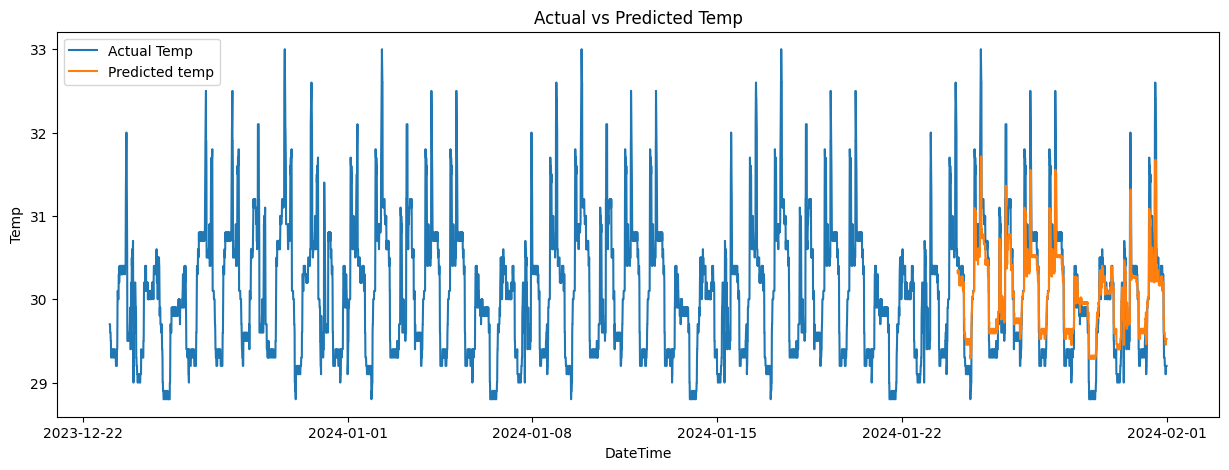

In [ ]:
# Plotting the Graph for Temp and DateTime
plt.figure(figsize=(15, 5))
plt.plot(df['DateTime'], df['Temp'], label='Actual Temp')
plt.plot(test_data['DateTime'], predictions, label='Predicted temp')
plt.xlabel('DateTime')
plt.ylabel('Temp')
plt.title('Actual vs Predicted Temp')
plt.legend()
plt.show()

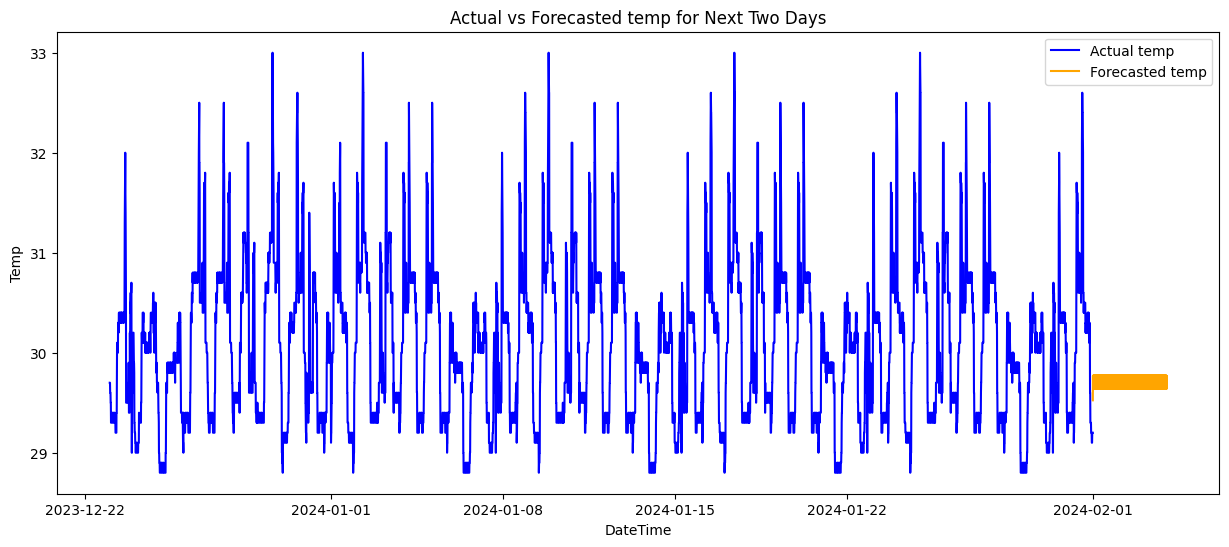

In [ ]:
# Extend the dataset by 2 days
extended_dates = pd.date_range(start='2024-02-01 00:00:00', end='2024-02-03 23:59:00', freq='10S')
extended_features = X_test.iloc[-1:].copy()  # Use the last row of the testing set as initial features for forecasting
extended_features['DateTime'] = extended_dates[0]  # Update DateTime to the start of the extended period

# Forecast temp for the extended period
forecasted_temp = []
for date in extended_dates:
    # Predict temp for the current DateTime
    forecast = xgb_model.predict(extended_features.drop(['DateTime'], axis=1))
    forecasted_temp.append(forecast[0])

    # Update features for the next forecast
    extended_features = extended_features.shift(periods=-1)  # Shift the lag features
    extended_features['lag_1'] = forecast  # Update lag_1 with the forecasted temp value
    extended_features['DateTime'] = date  # Update DateTime to the current forecast DateTime

# Plot actual vs predicted values for the extended period
plt.figure(figsize=(15, 6))
plt.plot(df['DateTime'], df['Temp'], label='Actual temp', color='blue')
plt.plot(extended_dates, forecasted_temp, label='Forecasted temp', color='orange')
plt.title('Actual vs Forecasted temp for Next Two Days')
plt.xlabel('DateTime')
plt.ylabel('Temp')
plt.legend()
plt.show()

In [ ]:
# Print forecasted temp values for the next two days
for date, temp_value in zip(extended_dates, forecasted_temp):
    print(f"Date: {date}, Forecasted Temp: {temp_value}")

Streaming output truncated to the last 5000 lines.
Date: 2024-02-03 10:05:50, Forecasted Temp: 29.77004623413086
Date: 2024-02-03 10:06:00, Forecasted Temp: 29.64312744140625
Date: 2024-02-03 10:06:10, Forecasted Temp: 29.77004623413086
Date: 2024-02-03 10:06:20, Forecasted Temp: 29.64312744140625
Date: 2024-02-03 10:06:30, Forecasted Temp: 29.77004623413086
Date: 2024-02-03 10:06:40, Forecasted Temp: 29.64312744140625
Date: 2024-02-03 10:06:50, Forecasted Temp: 29.77004623413086
Date: 2024-02-03 10:07:00, Forecasted Temp: 29.64312744140625
Date: 2024-02-03 10:07:10, Forecasted Temp: 29.77004623413086
Date: 2024-02-03 10:07:20, Forecasted Temp: 29.64312744140625
Date: 2024-02-03 10:07:30, Forecasted Temp: 29.77004623413086
Date: 2024-02-03 10:07:40, Forecasted Temp: 29.64312744140625
Date: 2024-02-03 10:07:50, Forecasted Temp: 29.77004623413086
Date: 2024-02-03 10:08:00, Forecasted Temp: 29.64312744140625
Date: 2024-02-03 10:08:10, Forecasted Temp: 29.77004623413086
Date: 2024-02-03 10